# TIF345/FYM345: Project 3: A Galton board on a rocking ship

# Names 
Jonatan Haraldsson [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

Jesper Noord [noord@chalmers.se](mailto:noord@chalmers.se)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import sklearn
import pandas as pd
import emcee
import numpy as np
import random
import tqdm
from tqdm import trange
import keras as keras
import tensorflow as tf

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

sns.set_palette('deep')
from matplotlib import cbook, cm
from seaborn import cm
from matplotlib.colors import LightSource
# plot in separate window
%matplotlib inline

rng = np.random.default_rng(seed = 42)

### Importing and massaging data

In [15]:
board_data = np.load('board_data.npy')

board_df = pd.DataFrame(board_data, columns = [f'bin_{i}' for i in range(32)])

display(board_df)


,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30,bin_31
0,0.0,0.0,0.0,2.0,5.0,9.0,11.0,28.0,31.0,47.0,...,8.0,8.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,...,78.0,59.0,57.0,34.0,26.0,7.0,6.0,2.0,1.0,0.0
2,0.0,0.0,0.0,1.0,4.0,8.0,19.0,18.0,27.0,47.0,...,11.0,5.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
3,1.0,8.0,13.0,57.0,79.0,85.0,116.0,109.0,119.0,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,...,88.0,54.0,70.0,28.0,25.0,14.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,76.0,75.0,54.0,36.0,26.0,11.0,2.0,3.0,0.0,0.0
9996,2.0,47.0,60.0,107.0,113.0,109.0,121.0,117.0,100.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,9.0,29.0,63.0,81.0,115.0,121.0,131.0,112.0,99.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,99.0,87.0,85.0,84.0,48.0,30.0,12.0,3.0,0.0


### Plots

Referring to the classical case with a Galton board, where the bead has an equal probability of bouncing to the left or the right, the distribution will converge to a binomial distribution for $N_\text{samples} \rightarrow\infty$.

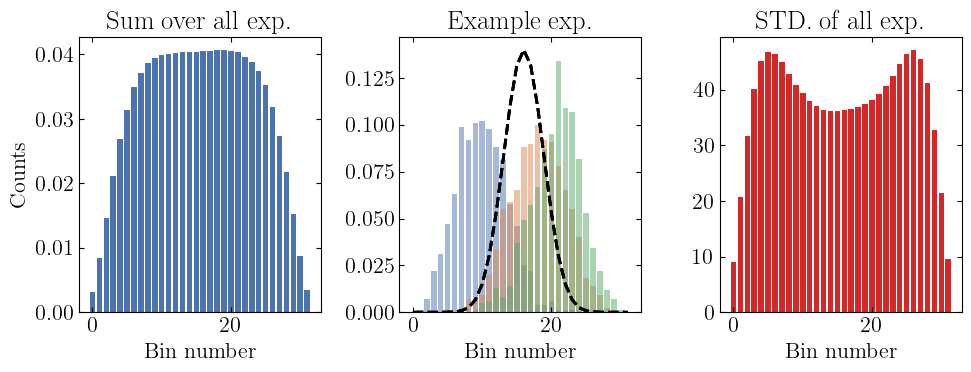

In [16]:

fig, ax = plt.subplots(1,3,figsize = (10, 4))

ax[0].bar(np.arange(32), board_data.sum(axis=0) / board_data.sum())
ax[0].set_xlabel('Bin number')
ax[0].set_ylabel('Counts')


for n in range(3):
    i = rng.integers(0, board_data.shape[0])
    ax[1].bar(np.arange(32), board_data[i]/ board_data[i].sum(),alpha=0.5)
    ax[1].plot(scipy.stats.binom.pmf(np.arange(32), n=32, p=1/2), color='black', lw=2,ls = '--')

ax[1].set_xlabel('Bin number')
ax[1].set_title('Example exp.')
ax[0].set_title('Sum over all exp.')
ax[2].set_title('STD. of all exp.')
ax[2].bar(np.arange(32), np.std(board_data,axis=0),color='tab:red')
ax[2].set_xlabel('Bin number')
plt.tight_layout()

plt.show()

In [17]:
def p_peg(alpha,s,left=None):
    if left == None:
        M = 0.
    elif left:
        M = 0.5
    else:
        M = -0.5
    return 0.5 + (alpha * M + s)

def p_peg_vec(alpha,s,left):
    M = np.zeros_like(left)
    M[left == True] = 0.5
    M[left == False] = -0.5
    p = 0.5 + (alpha * M + s)
    return p
    
def simulator(alpha,s, N=int(1e3)):
    rng = np.random.default_rng()
    bin_counts = np.zeros(32)

    left_bounces = np.zeros(32)
    left_ = np.zeros((N,32))


    for i in range(31):
        r = np.random.uniform(0,1,N)
        if i == 0:
            left_[:,i] = r <= (0.5 + s)
        else:
            left_[:,i] = r < p_peg_vec(alpha,s,left=left_[:,i-1])   
    left_bounces = np.sum(left_, axis=1)
    for bounces in left_bounces:
        bin_counts[int(bounces)] += 1
    return bin_counts 

32
32


<BarContainer object of 32 artists>

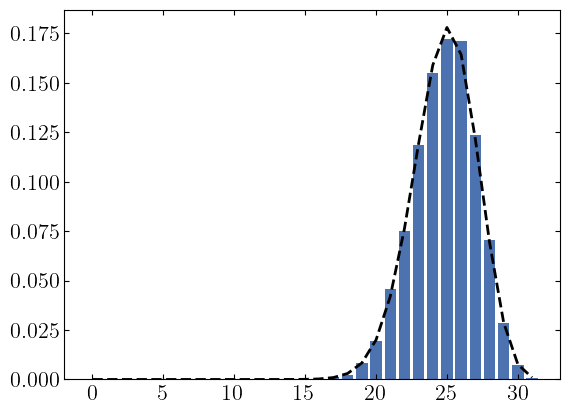

In [18]:
alpha = 0
s = 0.3
res = simulator(alpha,s,N=int(1e4))


#ind = np.argmax(res)


P = scipy.stats.binom.pmf(np.arange(32), n=31, p=p_peg(alpha,s))
plt.plot(P, color='black', lw=2,ls = '--')
print(len(P))

print(len(res))
plt.bar(np.arange(32), res/res.sum()) 

In [19]:
def statistic(data):
    x = np.arange(len(data))
    data = data / np.sum(data)
    exp_val = np.sum(data * x) 
    var = np.sum(data * (x - exp_val)**2)
    return exp_val, np.sqrt(var)

In [20]:
alphas = np.linspace(0,0.5,11)
ss = np.linspace(-0.25,0.25,11)
means = np.zeros((len(alphas), len(ss)))
variances = np.zeros((len(alphas), len(ss)))
for i, alpha in enumerate(alphas):
    for j, s in enumerate(ss):
        res = simulator(alpha,s)
        mean, var = statistic(res)
        means[i,j] = mean
        variances[i,j] = var

In [21]:
def grid_gen(xlim, ylim, size=50):
    x = np.linspace(xlim[0], xlim[1], size)
    y = np.linspace(ylim[0], ylim[1], size)
    X, Y = np.meshgrid(x, y)
    return X, Y


def contour_generator(xlim, ylim, size=50):
    X, Y = grid_gen(xlim, ylim, size)
    Z1 = np.zeros_like(X)
    Z2 = np.zeros_like(X)

    for i in trange(X.shape[0]):
        for j in range(X.shape[1]):
            res = simulator(X[i, j], Y[i, j])
            mean, var = statistic(res)
            Z1[i, j] = mean
            Z2[i, j] = var
    return X, Y, Z1, Z2

In [22]:
A,S,MEAN,STD = contour_generator((0,0.5),(-0.25,0.25),size=100)

100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


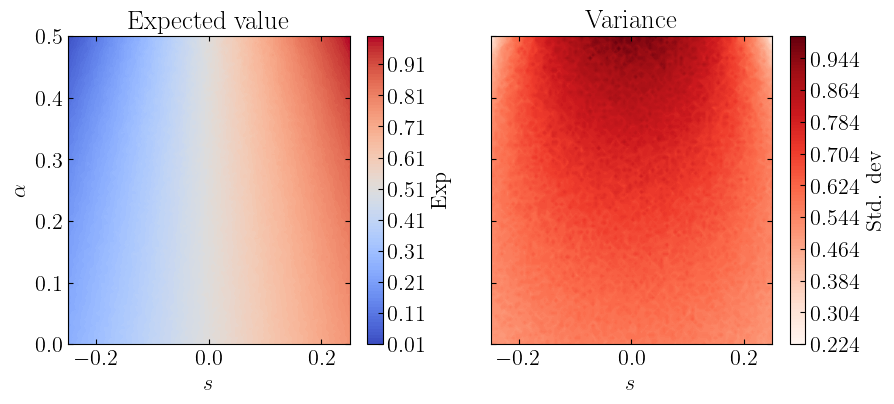

In [23]:
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True) 
conf0 = ax[0].contourf(S,A , MEAN/ np.max(MEAN), levels=100, cmap='coolwarm')
#ax[0].contour(A, S, Z, levels=100, c='k',alpha =0.5)
conf1 = ax[1].contourf(S, A, STD / np.max(STD) , levels=100, cmap='Reds')
ax[0].set_title('Expected value')
ax[1].set_title('Variance')
ax[0].set_ylabel(r'$\alpha$')
ax[0].set_xlabel(r'$s$')
ax[1].set_xlabel(r'$s$')

fig.colorbar(conf0, ax=ax[0],label='Exp')
fig.colorbar(conf1, ax=ax[1],label='Std. dev')#'$\\mathbb{COV}$ [eV$^2$]')

#plt.savefig('contour_plots.pdf', bbox_inches='tight')



In [24]:
def generate_data(N_samples):
    train_data = np.zeros((N_samples,32))
    target_data = np.zeros((N_samples,2))
    for n in trange(N_samples):
        s = np.random.uniform(-0.25,0.25)
        a = np.random.uniform(0,0.5)
        train_data[n,:] = simulator(a,s)
        target_data[n,0] = a
        target_data[n,1] = s
    return train_data, target_data
    

def generate_data_mesh(N_samples):
    train_data = np.zeros((N_samples**2,32))
    target_data = np.zeros((N_samples**2,2))
    s = np.random.uniform(-0.25,0.25,N_samples)
    a = np.random.uniform(0,0.5,N_samples)
    A,S = np.meshgrid(a,s)
    A = A.ravel()
    S = S.ravel()
    for n in trange(N_samples**2):
        train_data[n,:] = simulator(A[n],S[n])
        target_data[n,0] = A[n]
        target_data[n,1] = S[n]
    return train_data, target_data


# train_data, target_data = generate_data(50000)
# np.save('train_data.npy', train_data)
# np.save('target_data.npy', target_data)

100%|██████████| 50000/50000 [00:41<00:00, 1191.46it/s]


In [25]:
data = np.load('train_data.npy')
target = np.load('target_data.npy')

In [26]:
def kernel(y_pred, y_obs):
    sq = []
    D = []
    h = 5
    for i in range(len(y_pred)):
        diff = (statistic(y_pred[i,:].ravel())[0] - statistic(y_obs.ravel())[0]) / h
        sq.append(diff**2)
        D.append(diff)
    SQ = np.array(sq)
    return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))

In [87]:
def kernel(N, A, S, y_obs, mode='mean',h=5, h_std=5):
    sq = np.zeros(N)
    for i in range(N):
        if mode == 'mean':
            diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[0] - statistic(y_obs.ravel())[0]
            diff = diff**2 / h
        elif mode == 'std':   
            diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[1] - statistic(y_obs.ravel())[1]
            diff = diff**2 / h_std
        elif mode == 'both':
            diff_mean, diff_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
            diff = diff_mean**2/h + diff_std**2 / h_std**2
        elif mode == 'normal':
            diff_mean, diff_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
            diff = ((diff_mean**2 / h) / diff_std**2)
        else:
            raise ValueError("Mode must be 'mean', 'std', 'both' or 'normal'")
        sq[i] = diff
    return sq

In [88]:
def kernel_pred(y_obs,N=1000,h=1, mode = 'mean'):
    S = np.random.uniform(-0.25,0.25,N)
    A = np.random.uniform(0,0.5,N)
    #a = np.linspace(0,0.5,int(np.sqrt(N)))
    #s = np.linspace(-0.25,0.25,int(np.sqrt(N)))
    #A,S = np.meshgrid(a,s)
    #A = A.ravel()
    #S = S.ravel()
    h_std = h/4
    # for i in trange((N)):
    #     if mode == 'mean':
    #         diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[0] - statistic(y_obs.ravel())[0]
    #         diff = diff**2 / h
    #         D.append(diff)
    #     elif mode == 'std':   
    #         diff = statistic(simulator(alpha =A[i], s =S[i]).ravel())[1] - statistic(y_obs.ravel())[1]
    #         diff = diff**2 / h_std
    #         D.append(diff)
    #     elif mode == 'both':
    #         diff_mean, diff_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
    #         diff = np.sqrt(diff_mean**2/h**2 + diff_std**2 / h_std**2)
    #         D.append(diff)
    #     elif mode == 'normal':
    #         diff_mean, diff_std= np.array(statistic(simulator(alpha =A[i], s =S[i]).ravel())) - np.array(statistic(y_obs.ravel()))
    #         diff = ((diff_mean**2 / h) / diff_std**2)
    #         D.append(diff)
    #     else:
    #         raise ValueError("Mode must be 'mean', 'std', 'both' or 'normal'")
    #     sq.append(diff)
    
    SQ = kernel(N, A, S, y_obs, mode=mode,h=h, h_std=h_std)
    return np.sqrt(SQ), (np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))),A,S

In [73]:
def joint_plot(x,y,x_name,y_name):
    d = pd.DataFrame(np.vstack((x,y)).T,columns=[f'{x_name}',f'{y_name}'])
    #sns.jointplot(data=d, x=x_name, y=y_name, kind='kde', fill=True, cmap='Blues')
    g = sns.jointplot(data = d, x =x_name,y =y_name,ratio=3,space = 0,kind = 'hist')#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
    for coll in list(g.ax_joint.collections):
        coll.remove()
    g.plot_joint(sns.kdeplot,fill = True, cmap='Blues', levels = 15)
    g.plot_marginals(sns.histplot, bins=11, color="#9FC4DC", alpha=1)

In [146]:
t_obs = np.array([0.3,0.2])
y_obs = simulator(alpha=t_obs[0], s=t_obs[1], N=int(1e3))
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

D,P,a,s = kernel_pred(y_obs,N=10000,h=0.2,mode = 'both')   # Difference in summary statistics  # Kernel size / Probability

Observed parameters: alpha = 0.3, s = 0.2


In [160]:
def weighted_quantile(x, w, q):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    w = w / np.sum(w)

    idx = np.argsort(x)
    x_sorted = x[idx]
    w_sorted = w[idx]

    cdf = np.cumsum(w_sorted)
    return np.interp(q, cdf, x_sorted)

def weighted_ci(x, w, conf_level=0.95):
    alpha = 1.0 - conf_level
    lo = weighted_quantile(x, w, alpha/2)
    hi = weighted_quantile(x, w, 1 - alpha/2)
    return lo, hi

def corner_plot(a,s,P,t_obs):
    bins = 30
    a = a.ravel()
    s = s.ravel()
    P = P.ravel()
    fig, ax = plt.subplots(2,2,figsize=(7,6),sharex='col', sharey='row')
    ax[1,1].hist(s,bins=bins,weights=P,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
    ax[0,0].hist(a,bins=bins,weights=P,edgecolor='black', alpha=0.7,density=True,orientation='vertical')

    s_mean = np.sum(s * P)
    a_mean = np.sum(a * P)

    ax[0,0].axvline(a_mean,color='tab:green')
    ax[1,1].axhline(s_mean,color='tab:green')
    if t_obs is not None:
        ax[1,0].axhline(t_obs[1],color='tab:red',alpha = 0.4)
        ax[1,0].axvline(t_obs[0],color='tab:red',alpha = 0.4)
        ax[0,0].axvline(t_obs[0],color='tab:red',alpha = 0.4)
        ax[1,1].axhline(t_obs[1],color='tab:red',alpha = 0.4)

    ax[0,1].axis('off')

    ax[1,0].hist2d(a,s,bins=bins, weights=P, cmap='Blues')
    ax[1,0].set_ylabel('$s$')
    ax[1,0].set_xlabel('$\\alpha$')
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

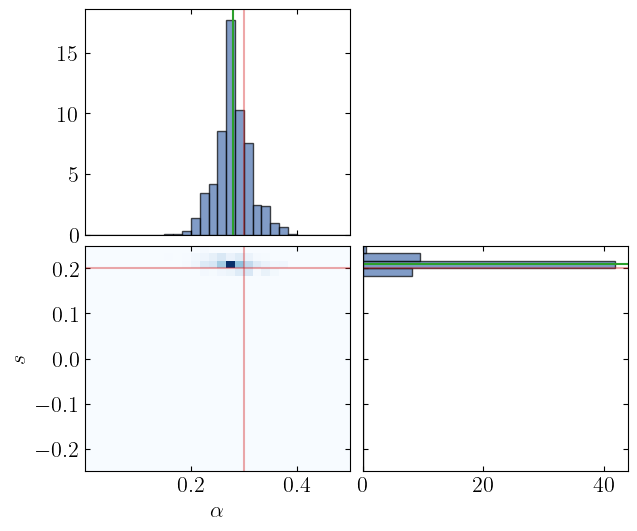

In [161]:
corner_plot(a,s,P,t_obs)

## Neural Network

In [31]:
fraction_train = 0.70; fraction_test = 0.10; fraction_valid = 1. - fraction_train - fraction_test

data_train = data[:int(fraction_train*len(data))]
target_train = target[:int(fraction_train*len(target))]

data_test = data[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(data))]
target_test = target[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(target))]

data_valid = data[int((fraction_train+fraction_test)*len(data)):]
target_valid = target[int((fraction_train+fraction_test)*len(target)):]

print(f"Training and target data size: {len(data_train)} x {len(target_train)} ")
print(f"Testing and target data size: {len(data_test)} x {len(target_test)} ")
print(f"Validation and target data size: {len(data_valid)} x {len(target_valid)} ")

Training and target data size: 35000 x 35000 
Testing and target data size: 5000 x 5000 
Validation and target data size: 10000 x 10000 


In [32]:
model = keras.models.Sequential([   
    keras.layers.Dense(64, activation='tanh', input_shape=(32,)),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(2,activation='tanh')
])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,258 (16.63 KB)

 Trainable params: 4,258 (16.63 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(
  optimizer='adam',
  loss='mse',metrics=['accuracy'])

In [34]:
epochs = 150     ## Number of epoch to run
batch_size = 32  ## Mini batch size

# Train the model.
history = model.fit(
  data_train, target_train,
  epochs=epochs,
  batch_size=batch_size,
  verbose = 0,
  validation_data=(data_valid, target_valid))

In [35]:
predictions = model.predict(data_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


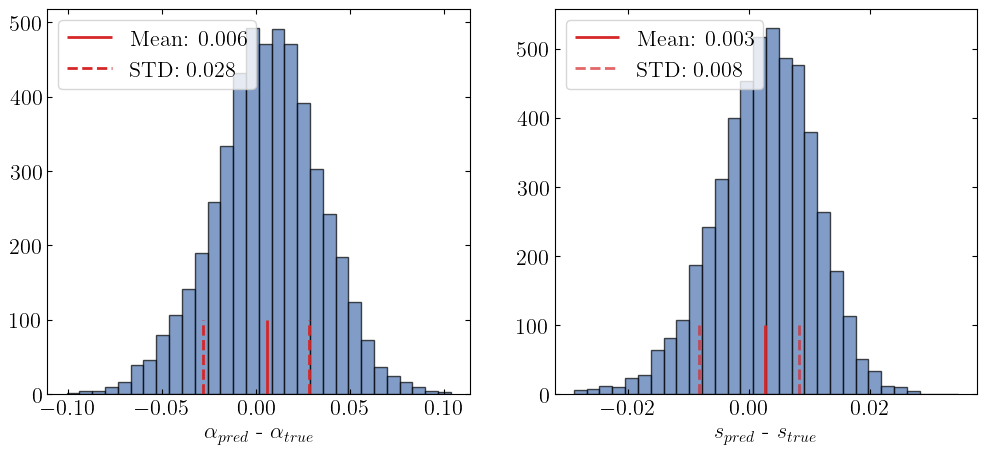

In [36]:
dif = predictions[:,0] - target_test[:,0]
dif1 = predictions[:,1] - target_test[:,1]

fig, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].hist(predictions[:,0] - target_test[:,0],bins = 30 ,edgecolor='black', alpha=0.7)
ax[0].vlines(np.mean(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='-', label = f'Mean: {np.mean(dif):.3f}')
ax[0].vlines(np.std(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='--', label = f'STD: {np.std(dif):.3f}')
ax[0].vlines(-np.std(dif), ymin=0, ymax=100, color='tab:red', lw=2, ls='--')
ax[0].set_xlabel('$\\alpha_{pred}$ - $\\alpha_{true}$')


ax[1].hist(predictions[:,1] - target_test[:,1],bins = 30,edgecolor='black', alpha=0.7)
ax[1].vlines(np.mean(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='-', label = f'Mean: ${np.mean(predictions[:,1] - target_test[:,1]):.3f}$')
ax[1].vlines(np.std(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='--',alpha=0.7, label = f'STD: ${np.std(predictions[:,1] - target_test[:,1]):.3f}$')
ax[1].vlines(-np.std(predictions[:,1] - target_test[:,1]), ymin=0, ymax=100, color='tab:red', lw=2, ls='--',alpha=0.7)
ax[1].set_xlabel('$s_{pred}$ - $s_{true}$')
ax[0].legend()
ax[1].legend()



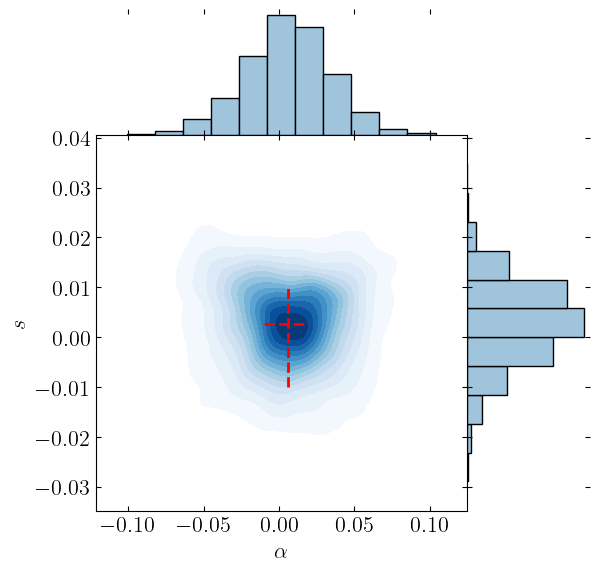

In [37]:

data = pd.DataFrame(np.vstack((dif,dif1)).T,columns=[r"$\alpha$",r'$s$'])
x = r'$\alpha$'; y = '$s$'
#sns.jointplot(data = data, x =x,y =y,ratio=3,space = 0,kind = 'kde',fill = True,cmap='Blues', levels = 15)#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
g = sns.jointplot(data = data, x =x,y =y,ratio=3,space = 0,kind = 'hist')#,joint_kws={'fill':True,'cmap':'Blues','levels':15})
for coll in list(g.ax_joint.collections):
    coll.remove()
g.plot_joint(sns.kdeplot,fill = True, cmap='Blues', levels = 15)
g.plot_marginals(sns.histplot, bins=11, color="#9FC4DC", alpha=1)

plt.vlines(np.mean(dif), -0.01, 0.01, color='red', lw=2, ls='--')
plt.hlines(np.mean(dif1), -0.01, 0.02, color='red', lw=2, ls='--')
#plt.vlines(0.5, -0.25, 0.25, color='red', lw=2, ls='--')
#plt.hlines(-0.25, 0, 0.5, color='red', lw=2, ls='--')
#plt.hlines(0.25, 0, 0.5, color='red', lw=2, ls='--')
plt.show()

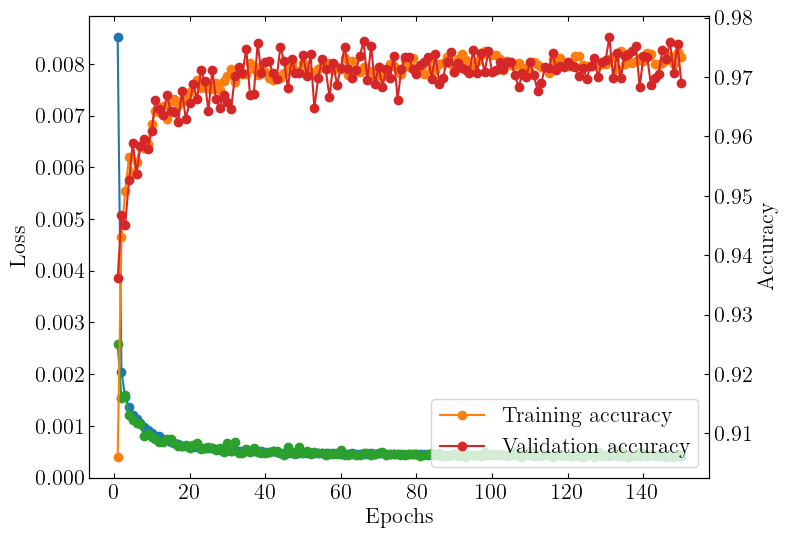

In [38]:
epochrange = range(1, epochs + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#plt.plot(epochrange, train_acc, 'bo', label='Training acc')
#plt.plot(epochrange, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy (modell 1)')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()
fig, ax = plt.subplots(figsize=(8, 6))

ax1 = ax.twinx()
ax.plot(epochrange, train_loss, '-o',color = 'tab:blue', label='Training loss')
ax.plot(epochrange, val_loss, '-o',color = 'tab:green', label='Validation loss')
ax1.plot(epochrange, accuracy, '-o',color = 'tab:orange', label='Training accuracy')
ax1.plot(epochrange, val_accuracy, '-o',color = 'tab:red', label='Validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')   
ax1.set_ylabel('Accuracy')   
plt.legend()
plt.show()

In [39]:
y_obs = simulator(alpha=t_obs[0], s=t_obs[1], N=int(1e3))
preds = model.predict(np.array([y_obs]))
print(f'Predicted parameters: alpha = {preds[0,0]}, s = {preds[0,1]}')  
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted parameters: alpha = 0.28006526827812195, s = 0.2085803747177124
Observed parameters: alpha = 0.3, s = 0.2


## ABC NN


In [ ]:
# def colonel_NN(model, y_obs, N=100, h=1, mode=None):
#     sq = []
#     D = []
#     a = np.random.uniform(0,0.5,int(N))
#     s = model.predict(np.array([y_obs]))[0,1] + np.random.normal(0.003,0.009,int(N))

#     for i in trange((N)):
#         if mode == 'mean':
#             diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[0] - statistic(y_obs.ravel())[0]
#         elif mode == 'std':   
#             diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[1] - statistic(y_obs.ravel())[1]
#         elif mode == 'both':
#             diff_mean, diff_std= np.array(statistic(simulator(alpha =a[i], s =s[i]).ravel())) - np.array(statistic(y_obs.ravel()))
#             diff = np.sqrt(diff_mean**2 + diff_std**2)
#         else:
#             raise ValueError("Mode must be 'mean', 'std', or 'both'")
#         sq.append(diff**2 / h)
#         D.append(diff)
#     SQ = np.array(sq)
#     D = np.array(D)
#     return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ))),a,s

In [97]:
def colonel_NN(model, y_obs, N=1000, h=1, mode = 'mean'):
    a = np.random.uniform(0,0.5,int(N))
    s = model.predict(np.array([y_obs]))[0,1] + np.random.normal(0.003,0.009,int(N))
    SQ = kernel(N, a, s, y_obs, mode=mode,h=h)
    D = np.sqrt(SQ)
    return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ))),a,s

In [164]:
D_NN,P_NN,a_nn,s_nn = colonel_NN(model, y_obs,N=1000,h=0.11,mode = 'mean')   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


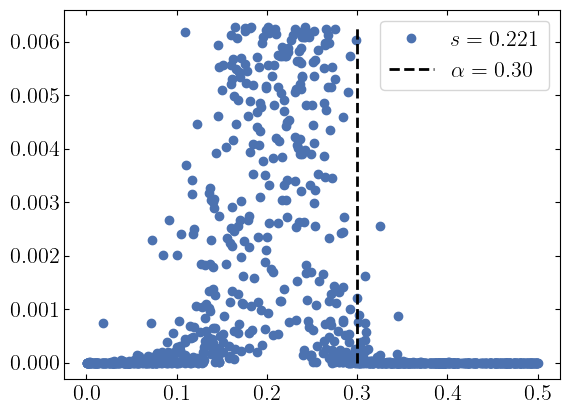

In [166]:
plt.plot(a_nn,P_NN,'o',label=f'$s = {s_nn[0]:.3f}$')
plt.vlines(t_obs[0], 0, np.max(P_NN), color='black', lw=2, ls='--',label=f'$\\alpha = {t_obs[0]:.2f}$')
plt.legend()

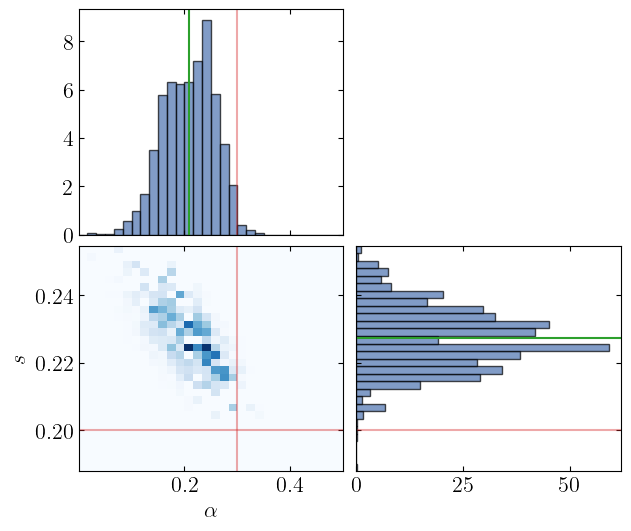

In [167]:
corner_plot(a_nn,s_nn,P_NN,t_obs)

## Chain of posterior

In [101]:
def statistic_2(data,x):
    data = data / np.sum(data)
    exp_val = np.sum(data * x) 
    var = np.sum(data * (x - exp_val)**2)
    return exp_val, np.sqrt(var)

def kernel_chain(y_obs,N=500,N_chain = 5, h=1, mode=None):
    for j in trange(N_chain):
        sq = []
        D = []
        if j == 0: 
            s = np.random.uniform(-0.25,0.25,int(N))
            a = np.random.uniform(0,0.5,int(N))
        else:
            mu_s = statistic_2(P,s)[0]
            std_s = statistic_2(P,s)[1]
            mu_a = statistic_2(P,a)[0]
            std_a = statistic_2(P,a)[1] 
            s = scipy.stats.norm.rvs(mu_s, std_s, int(N))
            a = scipy.stats.norm.rvs(mu_a, std_a, int(N))
            #print(f'Chain {j}: mu_a = {mu_a}, std_a = {std_a}, mu_s = {mu_s}, std_s = {std_s}')

        SQ = kernel(N, a, s, y_obs, mode=mode,h=h)
        D = np.sqrt(SQ)
        # for i in range((N)):
        #     if mode == 'mean':
        #         diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[0] - statistic(y_obs.ravel())[0]
        #     elif mode == 'std':   
        #         diff = statistic(simulator(alpha =a[i], s =s[i]).ravel())[1] - statistic(y_obs.ravel())[1]
        #     elif mode == 'both':
        #         diff_mean, diff_std= np.array(statistic(simulator(alpha =a[i], s =s[i]).ravel())) - np.array(statistic(y_obs.ravel()))
        #         diff = np.sqrt(diff_mean**2 + diff_std**2)
        #     else:
        #         raise ValueError("Mode must be 'mean', 'std', or 'both'")
        #     sq.append(diff**2 / h)
        #     D.append(diff)
        # SQ = np.array(sq)
        # D = np.array(D)
        P = np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))
    return D, P,a,s

In [169]:
D_c,P_c,a_c,s_c = kernel_chain(y_obs,N_chain = 10,N=5000,h=10,mode = 'mean')   

100%|██████████| 10/10 [00:40<00:00,  4.06s/it]


Observed parameters: alpha = 0.3, s = 0.2


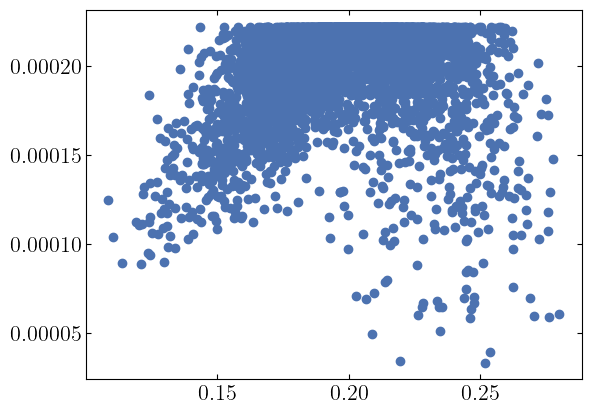

In [170]:
plt.plot(s_c,P_c,'o',label=f'$s = {s_nn[0]:.3f}$')
print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

#joint_plot(a_c,s_c,'$\\alpha$','$s$')

/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_79875/1447628554.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0,0].legend()
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_79875/1447628554.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,1].legend()


Observed parameters: alpha = 0.3, s = 0.2


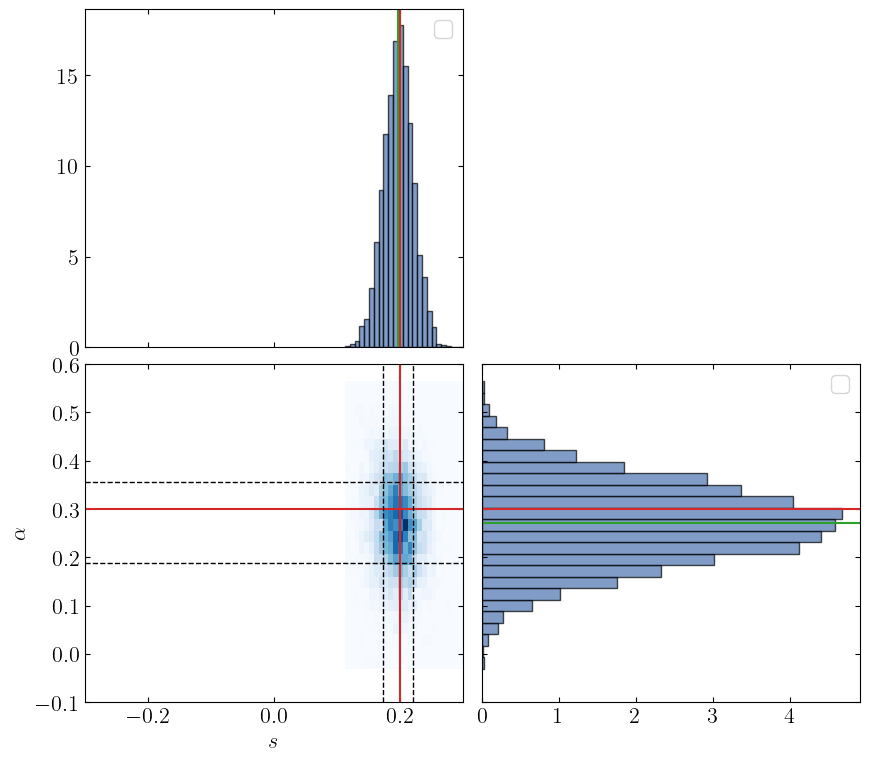

In [105]:

bins = 25
fig, ax = plt.subplots(2,2,figsize=(10,9),sharex='col', sharey='row')
ax[0,0].hist(s_c,bins=bins,weights=P_c,edgecolor='black', alpha=0.7,density=True,orientation='vertical')
ax[1,1].hist(a_c,bins=bins,weights=P_c,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
ax[1,0].axhline(t_obs[0],color='tab:red')
ax[1,0].axvline(t_obs[1],color='tab:red')
s_lo, s_hi = weighted_ci(s_c, P_c, 0.68)
a_lo, a_hi = weighted_ci(a_c, P_c, 0.68)

s_mean = np.sum(s_c * P_c)
a_mean = np.sum(a_c * P_c)

ax[1,1].axhline(a_mean,color='tab:green')
ax[0,0].axvline(s_mean,color='tab:green')

ax[1,1].axhline(t_obs[0],color='tab:red')
ax[0,0].axvline(t_obs[1],color='tab:red')



ax[1,0].axvline(s_lo,  color='black', linewidth=1, ls='--')
ax[1,0].axvline(s_hi, color='black', lw=1, ls='--')
ax[1,0].axhline(a_lo, color='black', lw=1, ls='--')
ax[1,0].axhline(a_hi, color='black', lw=1, ls='--')




ax[0,1].axis('off')

print(f'Observed parameters: alpha = {t_obs[0]}, s = {t_obs[1]}')

ax[0,0].legend()
ax[1,1].legend()

ax[1,0].hist2d(s_c,a_c,bins=bins, weights=P_c, cmap='Blues')
ax[1,0].set_xlabel('$s$')
ax[1,0].set_ylabel('$\\alpha$')
ax[1,0].set_xlim([-0.3,0.3])
ax[1,0].set_ylim([-0.1,0.6])
#plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('abc_posterior.pdf', bbox_inches='tight')

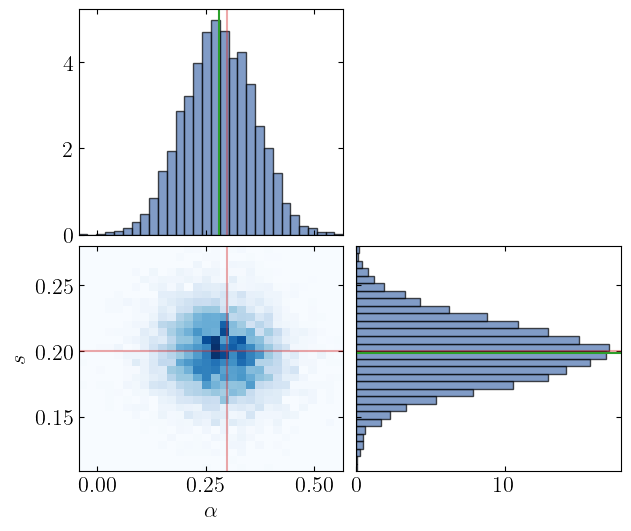

In [ ]:
corner_plot(a_c,s_c,P_c,t_obs)
plt.savefig('figs/abc_corner.pdf', bbox_inches='tight')

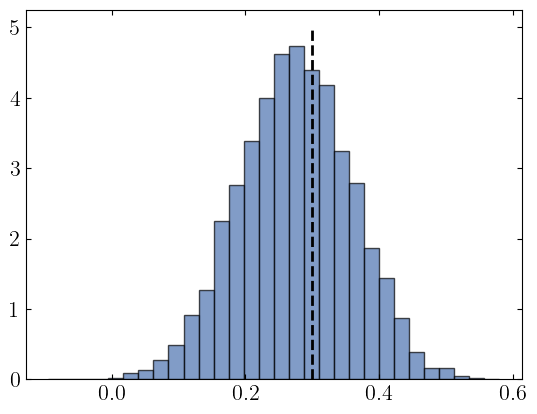

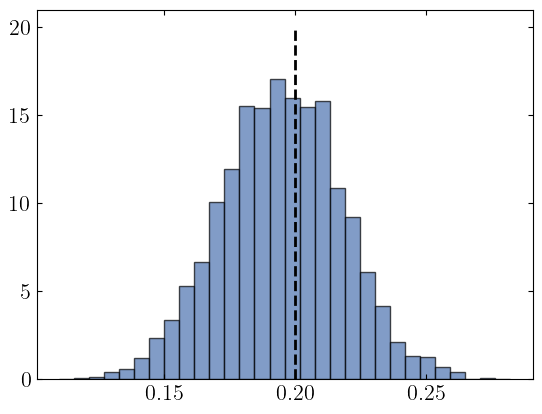

In [49]:
plt.hist(a_c,bins=30,weights=P_c,edgecolor='black', alpha=0.7,density=True)#,weights=P_§c,edgecolor='black', alpha=0.7)
plt.vlines(t_obs[0], 0, 5, color='black', lw=2, ls='--',label=f'$\\alpha = {t_obs[0]:.2f}$')
plt.show()
plt.hist(s_c,bins=30,weights=P_c,edgecolor='black', alpha=0.7,density=True)#,weights=P_§c,edgecolor='black', alpha=0.7)
plt.vlines(t_obs[1], 0, 20, color='black', lw=2, ls='--',label=f'$s = {t_obs[1]:.2f}$')
plt.show()

In [130]:
def kernel_chain_nn(Y_obs,N=500,N_chain = 5, h=1, mode=None,model = model):
    rng = np.random.default_rng(seed=42)
    k = rng.uniform(0,1,N_chain) * len(Y_obs)
    k = k.astype(int)
    A = np.zeros((N_chain,2))
    A_NN = []
    for j in range(N_chain):
        y_obs = Y_obs[k[j],:].ravel()
        s = model.predict(np.array([y_obs]),verbose = 0)[0,1] * np.ones(N) #+ scipy.stats.norm.rvs(-0.003,0.009)
        
        A_NN.append(model.predict(np.array([y_obs]),verbose = 0)[0,0])
        
        mu_obs, std_obs = statistic(y_obs)

        S = []
        sq = []
        D = []
        if j == 0: 
            a = np.random.uniform(0,0.5,int(N))
            A[j,0] = np.mean(a)
            A[j,1]  = np.std(a)
        else:
            mu_a = statistic_2(P,a)[0]
            std_a = statistic_2(P,a)[1] 
            A[j,0] = mu_a
            A[j,1] = std_a
            #print(A[j,:])
            a = scipy.stats.norm.rvs(mu_a, std_a, int(N))
            #print(f'Chain {j}: mu_a = {mu_a}, std_a = {std_a}')
            print(f'{j}\t{A_NN[j]}\t{mu_a}')
        SQ = kernel(N, a, s, y_obs, mode=mode,h=h)
        P = np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))
    return np.sqrt(SQ), P,A,S, A_NN,a

In [131]:
yy = simulator(0.1,0.1)
print(model.predict(np.array([yy]),verbose = 0)[0,0])

0.09577434


NN prediction: alpha = 0.3413088023662567, s = 0.08074436336755753


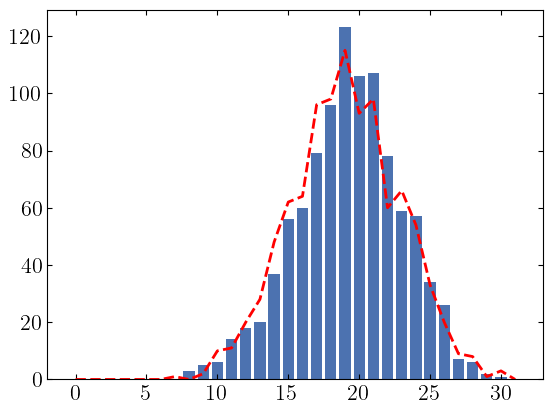

In [128]:
Y = np.load('board_data.npy') 

y_obs = Y[1,:].ravel()
a_nn,s  = model.predict(np.array([y_obs]),verbose = 0)[0,:]
print(f'NN prediction: alpha = {a_nn}, s = {s}')

plt.bar(np.arange(32), y_obs)
res = simulator(a_nn,s)
plt.plot(res, color='red', lw=2, ls='--')



In [132]:
D_c,P_c,A,s_c, A_NN, a_c = kernel_chain_nn(Y,N_chain = 400,N=500,h = 0.1,mode = 'mean')   

1	0.3026226758956909	0.2620016975792116
2	0.3233124613761902	0.2733259595258755
3	0.32366570830345154	0.29469243816304835
4	0.3602529466152191	0.29155302257737087
5	0.3847154676914215	0.30011230914817616
6	0.3646468222141266	0.3305523284471097
7	0.34800365567207336	0.3408694841792258
8	0.32211601734161377	0.3407923034134165
9	0.32767921686172485	0.33052864200582943
10	0.32601097226142883	0.3310190346901827
11	0.32215622067451477	0.3298278274423538
12	0.3546525239944458	0.3265270549667425
13	0.302700936794281	0.3271124174164476
14	0.30259969830513	0.31689635495597634
15	0.38501685857772827	0.31352043939564733
16	0.3485059440135956	0.314015544275281
17	0.33716586232185364	0.31377949850288833
18	0.3324528634548187	0.31301983126967237
19	0.3653964400291443	0.3121029027540799
20	0.38984906673431396	0.3122319755633085
21	0.3432052731513977	0.3189987079822972
22	0.3494340181350708	0.3221205632760171
23	0.366881787776947	0.3237762248503563
24	0.332569420337677	0.32372058937255155
25	0.34148326

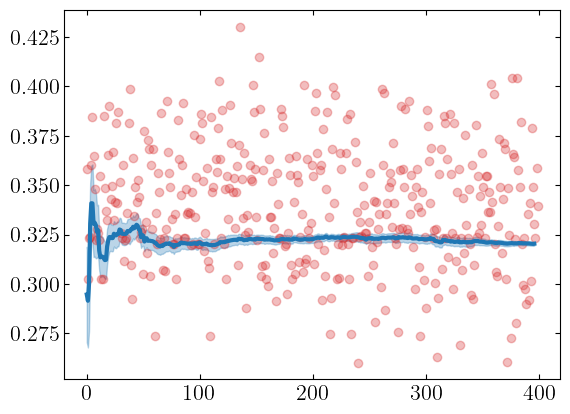

In [133]:
frac = 3

plt.plot(A_NN,'o',color='tab:red', label=f'$\\alpha_{{NN}}$',alpha = 0.3)
plt.plot(A[frac:,0],color = 'tab:blue',lw = 3)
plt.fill_between(np.arange(len(A[frac:,0])), A[frac:,0]+A[frac:,1], A[frac:,0]-A[frac:,1], alpha=0.3,color = 'tab:blue')
#plt.hlines(A_NN,0,len(A_c[:,0]), color='tab:red', lw=2, ls='--',label=f'$\\alpha_{{NN}}$')

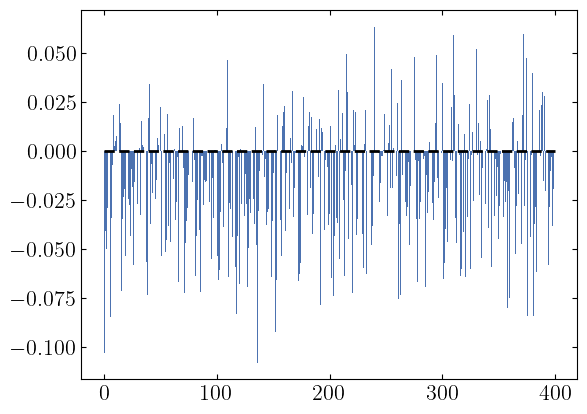

In [134]:
plt.bar(np.arange(len(A)),A[:,0] - A_NN[:])

plt.hlines(0,0,len(A[:,0]), color='black', lw=2, ls='--')


/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_79875/1487695443.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


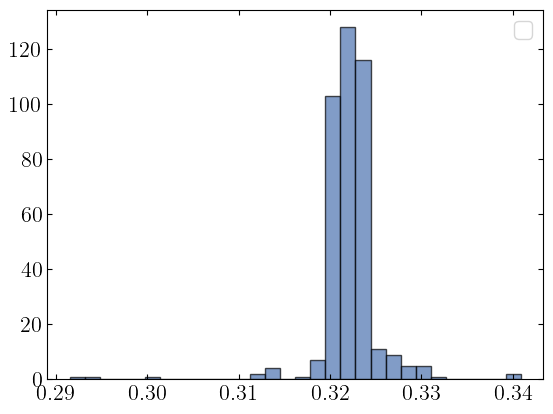

In [135]:
plt.hist(A[frac:,0], bins=30, edgecolor='black', alpha=0.7)
#plt.vlines(0,0,50, color='black', lw=2, ls='--')
#plt.vlines(np.mean(A[:,0]- A_NN[:]),0,50, color='tab:red', lw=2, ls='-', label=f'Mean: {np.mean(A[:,0]- A_NN[:]):.3f}')
plt.legend()

ValueError: weights should have the same shape as x

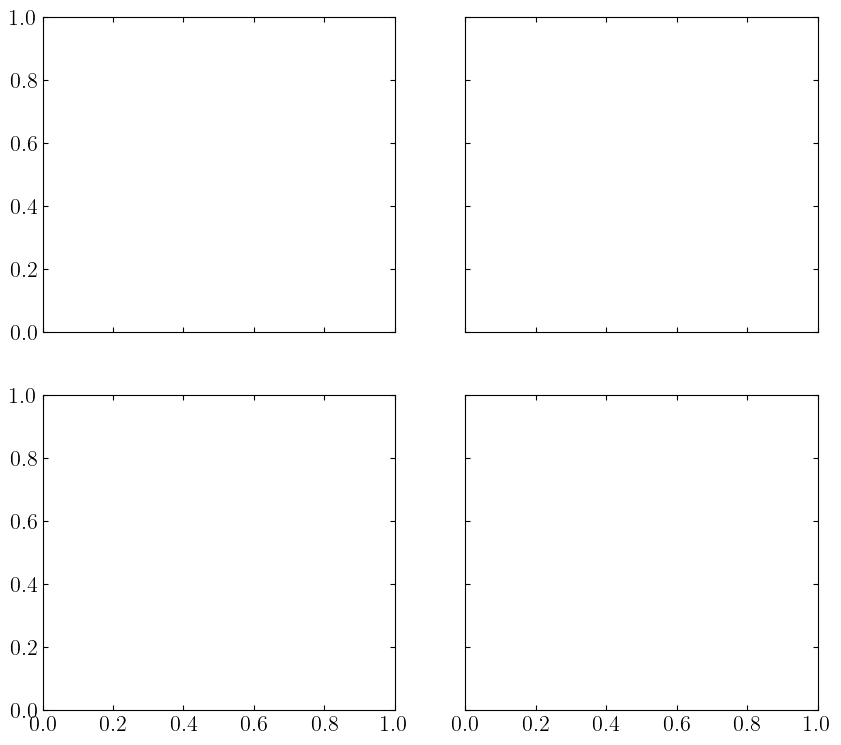

In [136]:

bins = 25
s_c = np.array(s_c)
fig, ax = plt.subplots(2,2,figsize=(10,9),sharex='col', sharey='row')
s_c = s_c.ravel()
P_c = P_c.ravel()
a_c = a_c.ravel()



ax[0,0].hist(s_c,bins=bins,weights=P_c,edgecolor='black', alpha=0.7,density=True,orientation='vertical')
ax[1,1].hist(a_c,bins=bins,weights=P_c,edgecolor='black', alpha=0.7,density=True,orientation='horizontal')
#ax[1,0].axhline(t_obs[0],color='tab:red')
#ax[1,0].axvline(t_obs[1],color='tab:red')
s_lo, s_hi = weighted_ci(s_c, P_c, 0.68)
a_lo, a_hi = weighted_ci(a_c, P_c, 0.68)

s_mean = np.sum(s_c * P_c)
a_mean = np.sum(a_c * P_c)

#ax[1,1].axhline(a_mean,color='tab:green')
#ax[0,0].axvline(s_mean,color='tab:green')

#ax[1,1].axhline(t_obs[0],color='tab:red')
#ax[0,0].axvline(t_obs[1],color='tab:red')



#ax[1,0].axvline(s_lo,  color='black', linewidth=1, ls='--')
#ax[1,0].axvline(s_hi, color='black', lw=1, ls='--')
#ax[1,0].axhline(a_lo, color='black', lw=1, ls='--')
#ax[1,0].axhline(a_hi, color='black', lw=1, ls='--')




ax[0,1].axis('off')

ax[0,0].legend()
ax[1,1].legend()

ax[1,0].hist2d(s_c,a_c,bins=bins, weights=P_c, cmap='Blues')
ax[1,0].set_xlabel('$s$')
ax[1,0].set_ylabel('$\\alpha$')
#plt.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('abc_posterior.pdf', bbox_inches='tight')